In [1]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings

# Setup

In [2]:
function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_r, MR$(n) --> 0
    δ_r, P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) σ_u$(i) ρ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end


FF_single_gene_ribosome_approx_sim (generic function with 1 method)

# Verifying the LNA solution

In [21]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+1), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 1000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

1000001-element Vector{Int64}:
 15
 14
 16
 14
 11
 10
 11
 11
 12
 14
 12
 12
 12
  ⋮
  9
  8
  9
 12
 13
 14
 15
 16
 14
 12
 15
 14

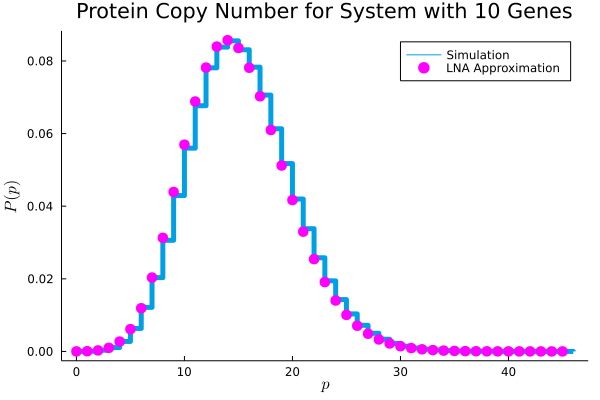

In [22]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [23]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

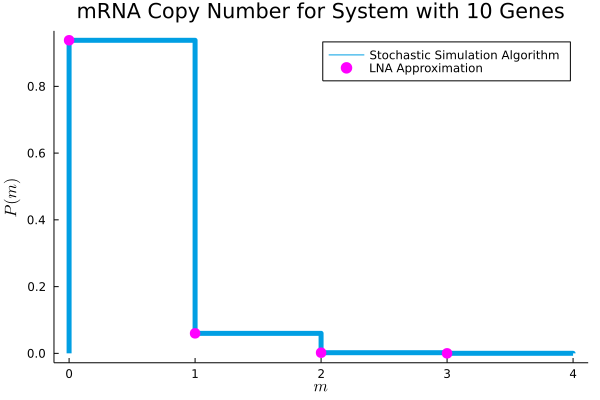

In [24]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [25]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")